In [550]:
# Install Packages
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk
from scipy import stats

# from scipy.spatial import Voronoi, voronoi_plot_2d
# vor = Voronoi(predict_pts)
# voronoi_plot_2d(vor)
## https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
import contextily as ctx
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# Percolation 

## Load cleaned OSM networkx graph

In [2]:
place = 'City of London, Greater London, England, United Kingdom'
#place = 'London, England, United Kingdom'
#place = 'Greater London, England, United Kingdom'

In [3]:
G = ox.graph_from_place(place, network_type='drive', simplify=False)

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

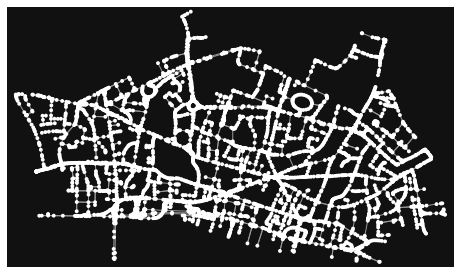

In [5]:
fig, ax = ox.plot_graph(G)

#### Save and reformat edgelist

In [6]:
# from loaded graph, generate an edgelist file and save locally
nx.write_edgelist(G, os.path.relpath("run_spercolation_inputs/london.edgelist"))

In [7]:
# open the edgelist as a list
with open(os.path.relpath("run_spercolation_inputs/london.edgelist")) as f:
    elist = []
    for item in f:
        elist.append(item)

In [8]:
# convert list to pandas dataframe and clean columns
edf = pd.DataFrame(elist)
edf = edf[0].str.split('{', expand=True)
edf[[1,2]] = edf[1].str.split('length', expand=True)
edf = edf[[0,2]]
edf[['0a','0b', '0c']] = edf[0].str.split(' ', expand=True)
edf[['2a','2b']] = edf[2].str.split(' ', expand=True)
edf[['2b','2c']] = edf['2b'].str.split('}', expand=True)
edf = edf[['0a','0b','2b']]
edf.rename(columns={'0a': 'i', '0b': 'j', '2b': 'w'}, inplace=True)
edf.set_index('i', inplace = True)
edf.to_csv(os.path.relpath("run_spercolation_inputs/londonijw.csv"))

In [9]:
# check that edgelist dataframe has columns: i, j, w
edf.head()

,j,w
i,,
104315,1832666032,11.685
104318,7946372941,3.667
104318,3817308660,6.032
104318,4076126448,11.158
104319,9781311298,30.976


## Run Percolation

In [10]:
# define percolation function
def run_spercolation(input_path, output_path, ps):
    """
    Function that runs the street percolation.
    
    input_path: path of the edgelist file in the format (i,j,w)
    output_path: desideredpath for the output files
    ps: array of percolation thresholds
    """
    
    #################### Preparing output folders

    #directory for membership tables
    dir_res_memb = output_path+'/membTables/' 
    if not os.path.exists(dir_res_memb): os.makedirs(dir_res_memb)

    #directory for cluster size tables    
    dir_clust_size = output_path+"/cluster_sizes/"
    if not os.path.exists(dir_clust_size): os.makedirs(dir_clust_size)
        
    #directory for cluster diameter tables    
    dir_clust_diam = output_path+"/cluster_diameters/"
    if not os.path.exists(dir_clust_diam): os.makedirs(dir_clust_diam)
        
    #file with global threshold info
    clusters_info_filename = output_path+"/clusters_info_p.txt"
    
    ########################################
    
    
    #Let us read the file that contains the list of nodes
    edgelist = pd.read_csv(input_path, sep=",")
    edgelist.columns = ['start_point','end_point','length']
    
    #Creating a file with global info on clusters given threshold p
    clusters_info_file = open(clusters_info_filename,'w')
    header = "threshold_p,n_clusters,LCC_id,LCC_size\n"
    clusters_info_file.write(header)
    
    for p in ps:
        #print('p=', p)
    
        #find sub-matrix such that all weights <= threshold p
        filtered_p = edgelist[edgelist['length']<=p]
        #print 'filtered'
    
        #create graph
        G = nx.from_pandas_edgelist(filtered_p, source='start_point', target='end_point', edge_attr='length',
                                create_using=nx.Graph())
        #print 'graph created'
        #nx.draw(G)
        
        #Creating a membership table file
        file_name = dir_res_memb+'membership_'+'p'+str(p)+'.txt'
        memb_table_file = open(file_name,'w')
        header = "node_id,cluster_id\n"
        memb_table_file.write(header)

        #Creating a cluster size file
        file_name = dir_clust_size+'clust_size_'+'p'+str(p)+'.txt'
        cluster_size_file = open(file_name,'w')
        header = "cluster_id,cluster_size\n"
        cluster_size_file.write(header)
        
        #Creating a cluster diameter file
        file_name = dir_clust_diam+'clust_diam_'+'p'+str(p)+'.txt'
        cluster_diam_file = open(file_name,'w')
        header = "cluster_id,cluster_diam\n"
        cluster_diam_file.write(header)

        #Looping over connected components
        LCC_size = 0 #initial value to store the size of the LCC
        LCC_id = None
        for cluster_id, cluster_nodes in enumerate(nx.connected_components(G)):

            #Saving cluster size to file
            cluster_size = len(cluster_nodes)
            line = "%i,%i\n"%(cluster_id, cluster_size)
            cluster_size_file.write(line)

            #Updating the value for the size of the LCC (I want to find the id)
            if cluster_size>LCC_size:
                LCC_size = cluster_size
                LCC_id = cluster_id

            #Looping over nodes in clusters and saving to membership table file 
            for n in cluster_nodes:
                line = "%i,%i\n"%(n,cluster_id)
                memb_table_file.write(line)
                
            g = G.subgraph(cluster_nodes)
            cluster_diam = nx.diameter(g)
            line = "%i,%i\n"%(cluster_id, cluster_diam)
            cluster_diam_file.write(line)
            
        #Saving global clusters info to file
        NCC = cluster_id+1 #last id index +1 since it started from 0
        line = str(p)+',%i,%i,%i\n'%(NCC,LCC_id,LCC_size)
        clusters_info_file.write(line)
        #print(NCC, 'connected components\n')

        memb_table_file.close()
        cluster_size_file.close()
        cluster_diam_file.close()

    clusters_info_file.close()

    return None

In [11]:
# Build array of percolation thresholds
thresholds = np.arange(5, 50, 1, dtype=int)

In [12]:
import time
start_time = time.time()

run_spercolation(os.path.relpath("run_spercolation_inputs/londonijw.csv"), 
                 os.path.relpath("run_spercolation_outputs"), 
                 thresholds)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1657.2698829174042 seconds ---


In [ ]:
# Visualise every 5 thresholds

### Plot Fractal Dimension

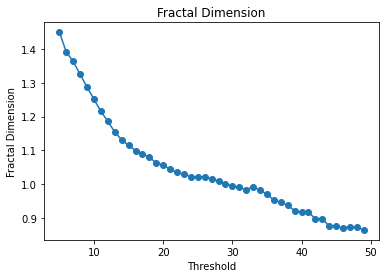

In [13]:
# Plot Fractal Dimension

'''
at each threshold, calculate fractal dimension a of clusters above a certain size
for minimum size, see  (see Raimbault for europe), or 600 elsa
fractal dimension 'a' is the power law relationship N=r^a , 
    where N = mass of cluster (number of intersections)
    and r = diameter of cluster (longest shortest path)
so logN = alogr    and     a = logr / logN    and     a = log(diam) / log(size)     for each threshold 
'''

output_path = os.path.relpath("run_spercolation_outputs")

#Reading data
clusters_info_filename = output_path + "/clusters_info_p.txt"
info = pd.read_csv(clusters_info_filename)

#file with fractal dimensions
fractal_dim_filename = output_path+"/fractal_dim_p.txt"

#Creating a file with fractal dimension given threshold p
fractal_dim_file = open(fractal_dim_filename,'w')
header = "threshold_p,fractal_dim\n"
fractal_dim_file.write(header)

#fractal = pd.DataFrame(columns=['threshold','fractal dimension'])

for p in info.threshold_p:
    size = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(p)+'.txt'))
    #print(min(size.cluster_size))
    #print(len(size))
    size = size[size.cluster_size > 1]  # ADJUST MIN SIZE HERE
    #print(len(size))
    diam = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_diameters/clust_diam_p"+str(p)+'.txt'))
    #diam.plot(x='cluster_id', y='cluster_diam', kind='scatter')
    x = np.log(size.cluster_size) # N = mass of cluster (number of intersections)
    y = np.log(diam.cluster_diam) # r = diameter of cluster (longest shortest path)
    #plt.scatter(x, y);
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    a = slope # a = fractal dimension
    
    #Saving fractal dimensions to file
    line = str(p) + ',' + str(a) + '\n' #'{}{}\n'.format(p,a) #  '%i'%(p) + str(a) + '\n'
    fractal_dim_file.write(line)

fractal_dim_file.close()

fractal = pd.read_csv(os.path.relpath("run_spercolation_outputs/fractal_dim_p.txt"))
plt.scatter(fractal.threshold_p, fractal.fractal_dim);
plt.plot(fractal.threshold_p, fractal.fractal_dim);
plt.title('Fractal Dimension')
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.show()
    
    
#spearman's with spatial lag
#gwr. 
#Rank Size,


### Plot Largest Connected Cluster

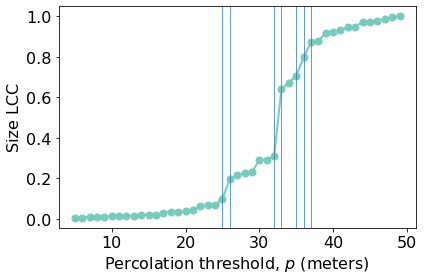

In [14]:
output_path = os.path.relpath("run_spercolation_outputs")
fig, ax = plt.subplots() #figsize=(5, 2.7)

#Reading data
clusters_info_filename = output_path + "/clusters_info_p.txt"
info = pd.read_csv(clusters_info_filename)

x = info['threshold_p']
y = info['LCC_size']/info['LCC_size'].max()

#Plotting
import matplotlib.ticker as ticker
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

rangec = np.linspace(0.2,0.95,5)
colors = [plt.cm.YlGnBu(i) for i in rangec]

ax.plot(x, y,'o-', markersize=7, color=colors[1], clip_on=True, mfc=colors[1],
    mec=colors[1], lw=2, label='Size LCC')

ax.set_xlabel(r'Percolation threshold, $p$ (meters)', size=16)
ax.set_ylabel('Size LCC', size=16)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.axvline(x=25, linewidth=0.7)
plt.axvline(x=26, linewidth=0.7)
plt.axvline(x=32, linewidth=0.7)
plt.axvline(x=33, linewidth=0.7)
plt.axvline(x=35, linewidth=0.7)
plt.axvline(x=36, linewidth=0.7)
plt.axvline(x=37, linewidth=0.7)
plt.tight_layout()


In [163]:
# Select Jumps
jumps = [25, 26, 32, 33, 35, 36, 37]

threshold = 25
LCC_id = 17, LCC_size = 397
LCC2_id = 2, LCC2_size = 277


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 26
LCC_id = 2, LCC_size = 786
LCC2_id = 7, LCC2_size = 261


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 32
LCC_id = 4, LCC_size = 1236
LCC2_id = 2, LCC2_size = 1174


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 33
LCC_id = 2, LCC_size = 2576
LCC2_id = 1, LCC2_size = 230


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 35
LCC_id = 2, LCC_size = 2833
LCC2_id = 1, LCC2_size = 230


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 36
LCC_id = 1, LCC_size = 3192
LCC2_id = 33, LCC2_size = 84


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


threshold = 37
LCC_id = 1, LCC_size = 3489
LCC2_id = 28, LCC2_size = 84


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


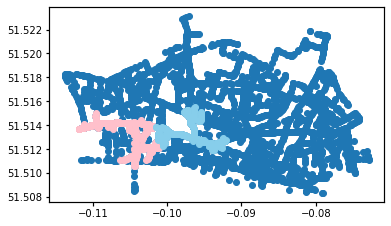

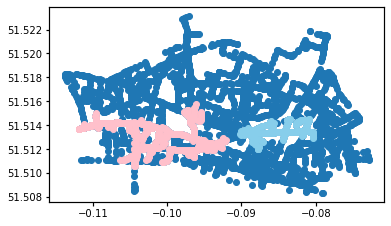

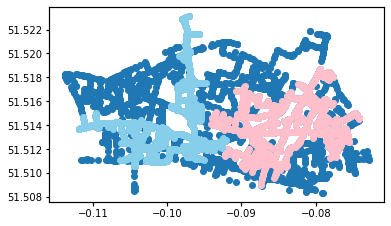

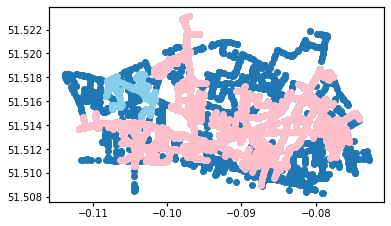

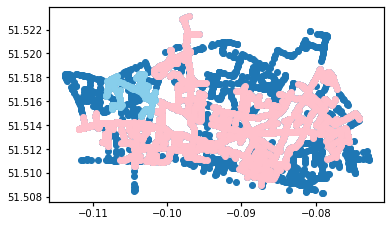

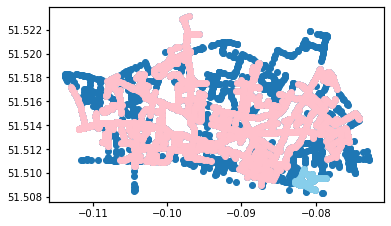

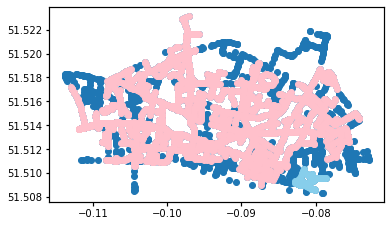

In [16]:
#Plot largest cluster in each jump
for moment in jumps:
    print('threshold = ' + str(moment))
    
    # find LCC_id in clusters_info_p.txt
    #info = pd.read_csv(os.path.relpath("run_spercolation_outputs/clusters_info_p.txt"))  #already loaded
    lccid = info[info['threshold_p'] == moment]['LCC_id'].values[0]
    lccsize = info[info['threshold_p'] == moment]['LCC_size'].values[0]
    print('LCC_id = ' + str(lccid) +', LCC_size = ' + str(lccsize))
    
    # find 2nd LCC_id from membTables
    memb = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p" + str(moment) + '.txt'))
    lccid2 = memb.groupby('cluster_id').count().sort_values('node_id', ascending = False).iloc[[1]].index[0]
    lccsize2 = memb.groupby('cluster_id').count().sort_values('node_id', ascending = False).iloc[[1]].node_id.values[0]
    print('LCC2_id = ' + str(lccid2) +', LCC2_size = ' + str(lccsize2))
    
    # find nodes in LCC_id in membTables
    lccnodes = memb[memb.cluster_id == lccid]
    lccnodes2 = memb[memb.cluster_id == lccid2]
    
    # plot nodes over london
    # fig, ax = ox.plot_graph(G.subgraph([1832666032, 1637578546, 8787692633]))
    #fig, ax = ox.plot_graph( G )
    #fig, ax = ox.plot_graph( G.subgraph( memb[memb['cluster_id']==lccid]["node_id"].tolist() ) )
    #nx.draw(S)
    
    # Plot clusters in each jump
    geo1 = pd.merge(gdf_nodes, lccnodes, right_on = 'node_id', left_on = 'osmid')
    geo2 = pd.merge(gdf_nodes, lccnodes2, right_on = 'node_id', left_on = 'osmid')
    base = gdf_nodes.plot()
    #fig, ax = ox.plot_graph(G)
    geo1.plot(ax = base, column = 'cluster_id', color='pink')
    geo2.plot(ax = base, column = 'cluster_id', color='skyblue')


### Plot Tree Graph

In [225]:
# Tree from apex
jumped = sorted(jumps, reverse=True)
for j in jumped:
    # tree level of this jump
    level = jumped.index(j)
    print(level)
    # retrieve the nodes in this jump
    jump = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p"+str(j)+'.txt')) 
    jump['level'] = level
    jump = jump[['level', 'node_id', 'cluster_id']]
    
    # subset clusters of a minimum size
    sizes = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(j)+'.txt'))
    clusters = sizes[sizes.cluster_size > 2] 
    nodes = pd.merge(jump, clusters, on='cluster_id').add_suffix(level) 
    
    # queen node
    if level == 0:
        # just the queen and her children
        forest = nodes[nodes.cluster_size0 == nodes.cluster_size0.max()].copy()
        edgelist = pd.DataFrame(columns=['Child','Parent','Child_Level','Parent_Level'])
        sizelist = forest[['cluster_id' + str(level), 'cluster_size' + str(level), 'level' + str(level)]]
        sizelist = sizelist[sizelist.duplicated() == False]
        sizelist.columns = ['Cluster','Size','Level']
    
    else:
        # in the cluster forest, branches that don't make it to the apex die. includes multiple queens.
        forest = pd.merge(forest, nodes, how = 'left',
                          left_on = forest.columns[1], right_on = nodes.columns[1])
        #print(forest.shape)
        
        edgelist_ = forest[['cluster_id' + str(level - 1), 'cluster_id' + str(level), 'level' + str(level - 1), 'level' + str(level)]]
        edgelist_ = edgelist_[edgelist_.duplicated() == False]
        edgelist_.columns = ['Parent','Child','Parent_Level','Child_Level']
        edgelist = pd.concat([edgelist, edgelist_])
        
        sizelist_ = forest[['cluster_id' + str(level), 'cluster_size' + str(level), 'level' + str(level)]]
        sizelist_ = sizelist_[sizelist_.duplicated() == False]
        sizelist_.columns = ['Cluster','Size','Level']
        sizelist = pd.concat([sizelist, sizelist_])
        
        
        #edgesizelist_.columns = ['Parent_Level','Parent', 'Parent_Size', 'Total_Children', 'Which_Child', 'Child', 'Child_Level', 'Child_Size']
        
#print("\njust nodes that feed into LCC at highest jump")
#forestqueen = forest[forest.cluster_size6 == forest.cluster_size6.max()]

0
1
2
3
4
5
6


In [226]:
# easier to merge edgelist and sizelist, and list parents number of children
edgelist

,Child,Parent,Child_Level,Parent_Level
0,1.0,1,1.0,0
24,34.0,1,1.0,0
25,11.0,1,1.0,0
47,64.0,1,1.0,0
60,61.0,1,1.0,0
...,...,...,...,...
2230,179.0,166.0,6.0,5.0
2276,230.0,214.0,6.0,5.0
2399,91.0,88.0,6.0,5.0
2650,130.0,121.0,6.0,5.0


In [222]:
edgelist.to_csv(os.path.relpath('Results_Trees/forest-edgelist.csv'))
sizelist.to_csv(os.path.relpath('Results_Trees/forest-sizelist.csv'))

In [188]:
print(len(forest.cluster_id1.unique()), forest.cluster_size1.max())
print(len(forest.cluster_id2.unique()), forest.cluster_size2.max())
print(len(forest.cluster_id3.unique()), forest.cluster_size3.max())
print(len(forest.cluster_id4.unique()), forest.cluster_size4.max())
print(len(forest.cluster_id5.unique()), forest.cluster_size5.max())
print(len(forest.cluster_id6.unique()), forest.cluster_size6.max())
print("\njust nodes that feed into LCC at highest jump")
forest2 = forest[forest.cluster_size6 == forest.cluster_size6.max()]
print(forest.shape[0], forest2.shape[0])
print(forest2.cluster_id6.unique())
#just cluster ID
forest3 = forest2[["cluster_id0",
                  "cluster_id1",
                  "cluster_id2",
                  "cluster_id3",
                  "cluster_id4",
                  "cluster_id5",
                  "cluster_id6"]]
#same nodes
#forest.node_id0.shape, forest.node_id0[forest.node_id0==forest.node_id6]

1 nan
1 nan
1 nan
1 nan
1 nan
1 nan

just nodes that feed into LCC at highest jump
4439 0
[]


## Twitter <a class="anchor" id="Twitter"></a>

In [19]:
pip install tweepy

     |████████████████████████████████| 94 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 5.0 MB/s eta 0:00:01     |██████▌                         | 30 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 943 kB/s  eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
Note: you may need to restart the kernel to use updated packages.


In [20]:
import tweepy

In [21]:
consumer_key = 'OhodPre22PW05EhvnRMcDhBvW'   #API_Key
consumer_secret = 'a3mj4spvrFsiW2WQ249YLqQdTWZJ2d1fM6tsFpB8qS5E7ui9gL' #API_Key_Secret
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAFJTcwEAAAAA9BqCpM7oqfUOBGY27GqunjvjERY%3Ds5HZgaNtbVN0uGYAjxxFCiLe06t1Q2Kmvtr5xaWH8BM1cGZepe'
access_token = '4819546558-yxe5pPjXBsPF6e11M24dhNaRLS3DNdYS7fPTZ89'
access_token_secret = '3qRpq5mNjIzjDkOFelXiPYWVR21gA1sziNHxeBCkN1gnT'

In [22]:
auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)
client = tweepy.Client(bearer_token)
#https://docs.tweepy.org/en/stable/examples.html

https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product

https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query#adding-a-query

https://onemilliontweetmap.com/?center=52.14023120108506,1.9775390625000002&zoom=3&search=&timeStep=0&timeSelector=0&hashtag1=&hashtag2=sad&sidebar=yes&hashtagBattle=0&timeRange=0&timeRange=25&heatmap=0&sun=0&cluster=0

https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research

In [23]:
q="covid -is:retweet"
response = tweepy.Paginator(client.search_recent_tweets, 
                            q, 
                            tweet_fields=["id","author_id","lang",'geo'],
                            place_fields=['contained_within','country','country_code','full_name','geo','id','name','place_type'],
                            max_results=100
                           ).flatten(limit=105)
tweets = pd.DataFrame(response)
tweets.shape

(105, 4)

In [24]:
tweets[tweets.geo.notna()]

AttributeError: 'DataFrame' object has no attribute 'geo'

In [ ]:
# read cosign similarity
# read shannon diversity
# read ranksize
find city between nuts 
interpolate dna
# find fractal thing elsa mentioned
#Bokeh for everything
are there fractals in ai

compare with random network
daphne used method of changing the location of polygon randomly





In [ ]:
places = api.search_geo(query="USA",granularity="country")
place_id = places[0].id
tweets = api.search(q="place:%s" % place_id)

## TOC:
* [Percolation](#Percolation)
* [Tree](#Tree)
* [Twitter](#Twitter)
* [ESS-NUTS](#ESS)
* [DNA](#DNA)
* [Imagery](#Imagery)
* [Bokeh](#Bokeh)

# ESS

In [591]:
ess9 = pd.read_csv(os.path.relpath("Data/ESS9-20220626.csv"))
print(ess9.shape)
#ess9.iloc[:, [5,9]]

(49519, 32)


In [592]:
#https://www.eea.europa.eu/data-and-maps/data/waterbase-lakes-4/country-codes-and-abbreviations-32-records/country-codes-and-abbreviations-32-records
key = ess9.iloc[:, [5,9]]
cntrycodes = pd.read_csv(os.path.relpath("Data/iso3166_alpha2_codes.csv"))
countrykey = pd.merge(key, cntrycodes, left_on = "cntry", right_on = "ISO2")
novcolor = pd.read_csv(os.path.relpath("Data/ColorTablePCmap-20220627.txt"), sep='\t', header = None)
novcolor.columns = ['country', 'color']
novcolor.loc[16,'color'] = 'red1'
countrycolors = pd.merge(countrykey, novcolor, how = 'left', left_on = 'Country name', right_on = 'country')
countrycolors = countrycolors[['region', 'ISO2', 'country', 'color']]

In [593]:
# remove nonanswer answers
#ess9.columns.get_loc("ipcrtiv"), ess9.columns.get_loc("impfun")
ess9 = ess9.set_index('region').loc[:, 'ipcrtiv':'impfun']
ess9.replace(7, np.NaN, inplace = True)
ess9.replace(8, np.NaN, inplace = True)
ess9.replace(9, np.NaN, inplace = True)

In [594]:
# mean value per nut. reg means nutregion
ess9reg = ess9.groupby('region').mean()
ess9reg.head()
# ppca for nan, https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python
# https://ess-search.nsd.no/en/study/bdc7c350-1029-4cb3-9d5e-53f668b8fa74

,ipcrtiv,imprich,ipeqopt,ipshabt,impsafe,impdiff,ipfrule,ipudrst,ipmodst,ipgdtim,...,iphlppl,ipsuces,ipstrgv,ipadvnt,ipbhprp,iprspot,iplylfr,impenv,imptrad,impfun
region,,,,,,,,,,,,,,,,,,,,,
99999,2.000000,6.000000,1.000000,3.000000,4.000000,2.000000,5.000000,2.000000,3.000000,2.000000,...,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,2.000000,1.000000,5.000000,3.000000
AT11,2.726190,4.423529,1.940476,2.602410,2.000000,3.642857,2.951807,2.494118,2.811765,2.717647,...,1.951807,2.929412,2.130952,4.258824,2.082353,2.294118,1.529412,1.588235,1.870588,2.917647
AT12,2.708333,4.111842,2.386813,2.671053,2.103070,3.288840,2.869757,2.521930,3.026374,2.798246,...,2.245077,3.037118,2.039911,4.048035,2.324503,2.447368,1.634573,1.772926,2.531729,2.888158
AT13,2.258252,3.904669,1.867446,2.736842,2.223301,3.003899,3.159844,2.127202,2.994163,2.526316,...,2.040777,2.753398,2.365759,3.923977,2.430799,2.727984,1.581712,1.813592,3.001946,2.935922
AT21,2.558282,4.104294,2.006135,2.625767,1.662577,3.300613,3.155280,2.257669,2.705521,2.546584,...,2.024540,2.901235,2.000000,4.202454,2.171779,2.533742,1.693252,1.883436,2.147239,2.732919


### NUTS geo

In [589]:
#load nuts geo
nuts = gpd.read_file(os.path.relpath('Data/NUTS_RG_20M_2021_4326-20220626.geojson'))
nuts.crs

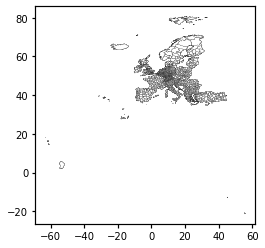

In [606]:
#merge with nuts geo
gdf_ess9 = pd.merge(nuts, ess9reg, left_on = 'NUTS_ID', right_index = True)

In [673]:
%%capture

#Check it looks right
hvals = list(gdf_ess9.loc[:,'ipcrtiv':'impfun'].columns)
for hval in hvals:
    i = hvals.index(hval) + 1
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.title(hval, size=20)
    nuts.plot(ax=ax, color='white',edgecolor='black', linewidth=0.2);
    gdf_ess9.plot(hval, cmap='OrRd_r', ax=ax, legend = True);
    #gdf_nodes.plot(ax=ax, color = 'red') #london
    ax.axis('on')
    plt.ylim(25, 83)
    plt.xlim(-30, 50)
    #plt.ylim(25, 35)
    #plt.xlim(-20, -10)
    #plt.show()
    fig.savefig(os.path.relpath('Figs/esshvs'+str(i)+'.png'), dpi=100) 

### Cosign Similarity

In [ ]:
ess9nodes = gpd.sjoin(gdf_nodes, gdf_ess9)

In [ ]:
jumps = [25, 26, 32, 33]

for j in jumps:
    level = jumps.index(j)
    # retrieve the nodes in this jump
    jump = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p"+str(j)+'.txt')) 
    jump['level'] = level
    jump = jump[['level', 'node_id', 'cluster_id']]
    
    # subset clusters of a minimum size
    sizes = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(j)+'.txt'))
    clusters = sizes[sizes.cluster_size > 2] 
    nodes = pd.merge(jump, clusters, on='cluster_id') #.add_suffix(level) 

    # add the ess9 weights to the nodes in this jump
    ess9jumpnodes = pd.merge(ess9nodes, nodes, how = 'right', left_index = True, right_on = 'node_id')
    
    # find the weighted average ess9 value for each cluster in this jump
    ess9jumpclusters = ess9jumpnodes.groupby('cluster_id').mean().sort_values('cluster_size', ascending = False)
    
    # calculate similarity between two largest clusters
    largest = ess9jumpclusters.iloc[[0]].loc[:,'ipcrtiv':'impfun']
    larger = ess9jumpclusters.iloc[[1]].loc[:,'ipcrtiv':'impfun']
    print(sk.pairwise.cosine_similarity(largest, larger))

## TOC:
* [Percolation](#Percolation)
* [Tree](#Tree)
* [Twitter](#Twitter)
* [ESS-NUTS](#ESS)
* [DNA](#DNA)
* [Imagery](#Imagery)
* [Bokeh](#Bokeh)

# DNA

### Colors

In [377]:
novcolor = pd.read_csv(os.path.relpath("Data/ColorTablePCmap-20220627.txt"), sep='\t', header = None)
novcolor.columns = ['country', 'color']
#novcolor.loc[16,'color'] = 'red1'
# https://r-charts.com/colors/
novcolor.color[novcolor.color=='gold1'] = '#FFD700'
novcolor.color[novcolor.color=='orange'] = '#FFA500'
novcolor.color[novcolor.color=='tan3'] = '#CD853F'
novcolor.color[novcolor.color=='yellow'] = '#FFFF00'
novcolor.color[novcolor.color=='yellowgreen'] = '#9ACD32'
novcolor.color[novcolor.color=='gold2'] = '#EEC900'
novcolor.color[novcolor.color=='gold3'] = '#CDAD00'
novcolor.color[novcolor.color=='aquamarine4'] = '#458B74'
novcolor.color[novcolor.color=='aquamarine2'] = '#76EEC6'
novcolor.color[novcolor.color=='aquamarine3'] = '#66CDAA'
novcolor.color[novcolor.color=='darkolivegreen2'] = '#BCEE68'
novcolor.color[novcolor.color=='green2'] = '#00EE00'
novcolor.color[novcolor.color=='green3'] = '#00CD00'
novcolor.color[novcolor.color=='green4'] = '#008B00'
novcolor.color[novcolor.color=='green'] = '#00FF00'
novcolor.color[novcolor.color=='pink'] = '#FFC0CB'
novcolor.color[novcolor.color=='red#lightblue'] = '#FF0000' #red1
novcolor.color[novcolor.color=='lightpink3'] = '#CD8C95'
novcolor.color[novcolor.color=='yellow'] = '#FFFF00'
novcolor.color[novcolor.color=='sienna'] = '#A0522D'
novcolor.color[novcolor.color=='dodgerblue1'] = '#1E90FF'
novcolor.color[novcolor.color=='darkseagreen4'] = '#698b69'
novcolor.color[novcolor.color=='darkseagreen'] = '#8FBC8F'
novcolor.color[novcolor.color=='dodgerblue3'] = '#1874CD'
novcolor.color[novcolor.color=='cadetblue1'] = '#98F5FF'
novcolor.color[novcolor.color=='deepskyblue2'] = '#00B2EE'
novcolor.color[novcolor.color=='deepskyblue4'] = '#00688B'
novcolor.color[novcolor.color=='cadetblue'] = '#5F9EA0'
novcolor.color[novcolor.color=='cadetblue3'] = '#7ac5cd'
novcolor.color[novcolor.color=='cadetblue2'] = '#8EE5EE'
novcolor.color[novcolor.color=='deepskyblue1'] = '#00BFFF'
novcolor.color[novcolor.color=='blue'] = '#0000FF'
novcolor.color[novcolor.color=='darkorchid3 '] = '#9A32CD' 
novcolor.color[novcolor.color=='violetred1'] = '#FF3E96'
novcolor.color[novcolor.color=='violetred3'] = '#CD3278'
novcolor.color[novcolor.color=='palevioletred2 '] = '#EE799F'
novcolor.color[novcolor.color=='orange'] = '#FFA500'
novcolor.color[novcolor.color=='orangered1'] = '#FF4500'
novcolor.color[novcolor.color=='springgreen4'] = '#008B45'
novcolor.color[novcolor.color=='red'] = '#0000FF'

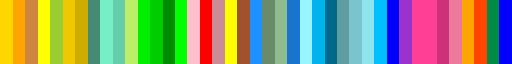

In [379]:
mpl.colors.ListedColormap(list(novcolor['color']),'novcmap')

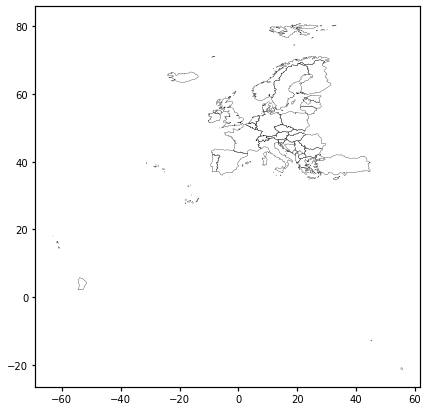

In [533]:
countries = nuts[nuts.LEVL_CODE==0].cx[-27:48, 34:80.78]
countries.boundary.plot(edgecolor="black", linewidth = 0.3, figsize=(7,7));
#countries.cx[-27:48, 34:80.78].plot(color='white', edgecolor='black');

### Figure 1 Data

In [583]:
# Load PCA results
pca = pd.read_csv(os.path.relpath("Data/Nov2008_PCA-20220622.txt"), delimiter='\t')
pca = pd.merge(pca, novcolor, how = 'left', left_on = 'plabels', right_on = 'country')
pca.head()

,ID_x,plabels,alabels,longitude,latitude,PC1,PC2,RotNS,RotEW,ID_y,country,color
0,474,Croatia,HR,16.1,45.32,0.0111,-0.046,0.04114,0.023381,474,Croatia,#1874CD
1,474,Croatia,HR,16.1,45.32,0.0111,-0.046,0.04114,0.023381,17669,Croatia,#1874CD
2,474,Croatia,HR,16.1,45.32,0.0111,-0.046,0.04114,0.023381,19593,Croatia,#1874CD
3,474,Croatia,HR,16.1,45.32,0.0111,-0.046,0.04114,0.023381,34699,Croatia,#1874CD
4,474,Croatia,HR,16.1,45.32,0.0111,-0.046,0.04114,0.023381,34723,Croatia,#1874CD


In [490]:
# ID to novcolor for later
novcolor = pca[['ID', 'country', 'color']]
novcolor.head()

,ID,country,color
0,474,Croatia,#1874CD
1,660,Serbia and Montenegro,#8EE5EE
2,1890,Czech Republic,#9ACD32
3,1923,Bosnia and Herzegovina,#5F9EA0
4,2083,Serbia and Montenegro,#8EE5EE


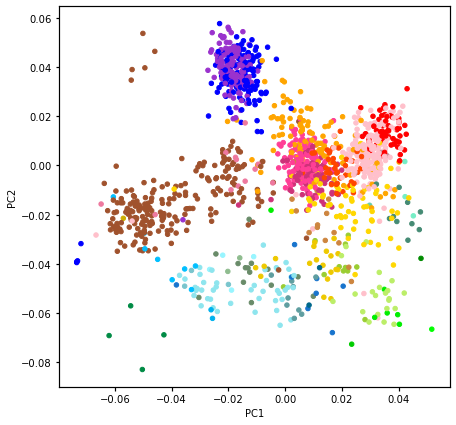

In [414]:
# Plot raw PC1 and PC2 per country; same as eigs 4.093 and 2.040
pcaPCA = gpd.GeoDataFrame(pca, #.drop(columns=['longitude','latitude'],inplace=True)
                          geometry=gpd.points_from_xy(pca.PC1, pca.PC2),
                          crs = 'EPSG:4326')
#pcaPCA.plot(color=pcaPCA.color, figsize=(7,7)); 
pca.plot.scatter(x='PC1', y='PC2', color=pca.color, figsize=(7,7)); 

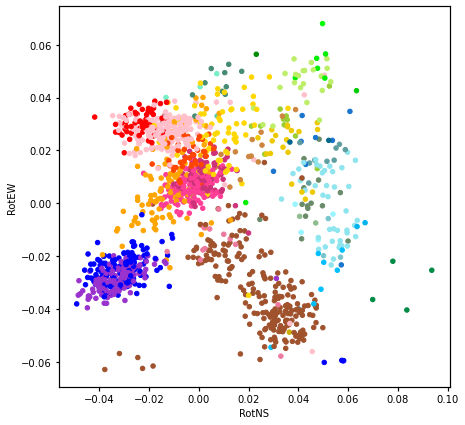

In [481]:
# Plot rotated PC1 and PC2 per country
#pcaROT = gpd.GeoDataFrame(pca, #.drop(columns=['PC1','PC2'],inplace=True), geometry=gpd.points_from_xy(pca.RotNS, pca.RotEW), crs = 'EPSG:4326')
#pcaROT.plot(color=pcaROT.color, figsize=(7,7)); #individuals PC1 and PC2 rotated values
pca.plot.scatter(x='RotNS', y='RotEW', color=pca.color, figsize=(7,7));

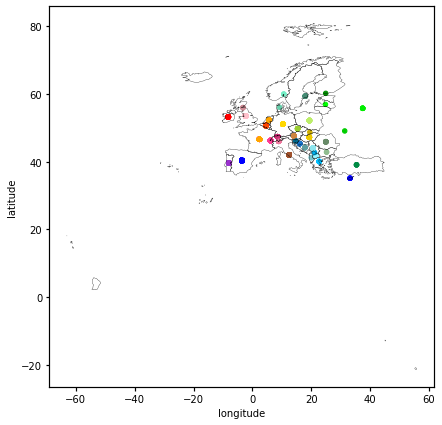

In [480]:
# Plot country centroids
#pcaCENT = gpd.GeoDataFrame(pca, geometry=gpd.points_from_xy(pca.longitude, pca.latitude), crs='EPSG:4263')
#pcaCENT.plot(color=pcaCENT.color); #ax=base
#len(pca.longitude.unique())
fig, ax = plt.subplots(figsize=(7,7))
countries.boundary.plot(ax=ax, edgecolor="black", linewidth=0.3);
pca.plot.scatter(ax=ax, x='longitude', y='latitude', color=pca.color);

In [588]:
# Load all PCA components, cleaning the columns
eigs = pd.read_fwf(os.path.relpath("Data/NovPCAeigs-20220627.txt"), width=[6,6,6,5,5])
eigs.columns = ['ID', '4.093', '2.040', 
                '1.537', #'1.435', 
                '1.387', '1.344', '1.343', 
                '1.339', #'1.337',
                '1.334', '1.331', '1.329', 
                '1.327', #'1.325', 
                '1.323', '1.322', '1.321', 
                '1.320', '1.319', '1.317',
                'control']
eigs[['1.537', '1.435']] = eigs['1.537'].str.split(expand=True)
eigs[['1.339', '1.337']] = eigs['1.339'].str.split(expand=True)
eigs[['1.327', '1.325']] = eigs['1.327'].str.split(expand=True)
eigs[['ID', 'ID2']] = eigs['ID'].str.split(expand=True)
eigs.drop(columns=['ID2', 'control'], inplace = True)
eigs = eigs.astype({'ID': 'int32'})
#eigs.set_index('DNAsample', inplace=True)
eigs.shape

(1387, 21)

### Figure 2 Data

In [493]:
# leave-one-out cross validation and the continuous assignment method
predict = pd.read_csv(os.path.relpath("Data/Nov2008_predict-20220627.csv"))
predict = predict[['V1', 'V2', 'V3']]
predict_pts = predict[['V2','V3']].values
predict.columns = ['ID', 'Longitude', 'Latitude']
predict = pd.merge(predict, novcolor, how = 'left', on='ID')
predict = gpd.GeoDataFrame(predict, geometry=gpd.points_from_xy(predict.Longitude, predict.Latitude), crs = 'EPSG:4326')


# locations used to train the assignment method
true = pd.read_csv(os.path.relpath("Data/Nov2008_true-20220627.csv"))
true = true[['V1', 'V2', 'V3']]
true.columns = ['ID', 'Longitude', 'Latitude']
true = pd.merge(true, novcolor, how = 'left', on='ID')
true = gpd.GeoDataFrame(true, geometry=gpd.points_from_xy(true.Longitude, true.Latitude), crs = 'EPSG:4326')

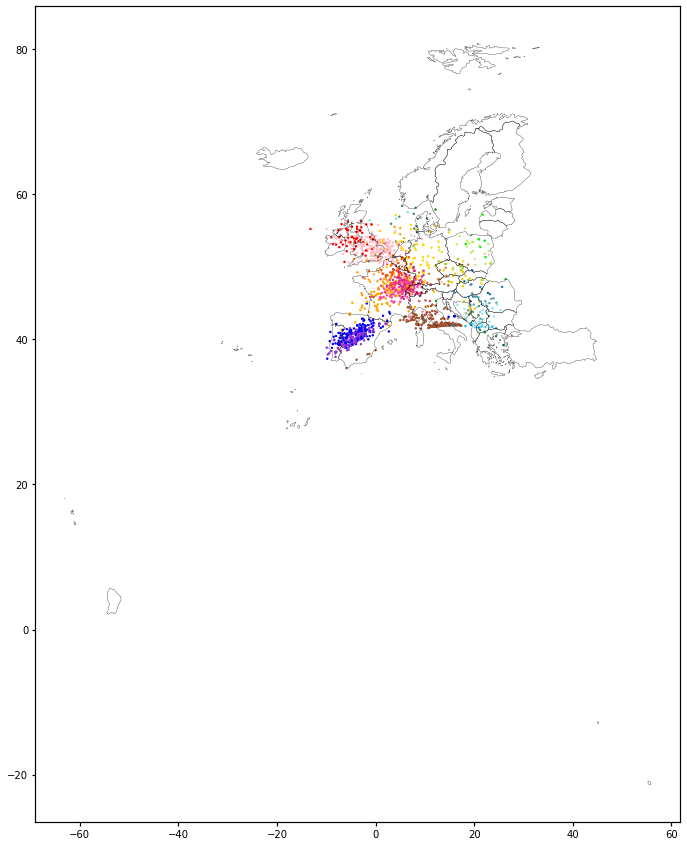

In [504]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#ax.legend(novcolor.country, novcolor.color)
#fig.set_dpi(200)
countries.boundary.plot(ax=ax, edgecolor="black", linewidth=0.3);
predict.plot(ax=ax, color=predict.color, markersize=2);
#true.plot(ax=ax, color=predict.color, markersize=6);
plt.show();

## Voronoi

In [565]:
#euro = countries.dissolve()

euro = gpd.read_file(os.path.relpath("Data/NUTS_RG_20M_2021_4326-20220626.geojson"))
euro = euro[euro.LEVL_CODE != 0].cx[-27:48, 34:80.78]
#euro = gpd.clip(euro, bbox)
#euro.crs
euro = euro.dissolve().to_crs(epsg=4326)

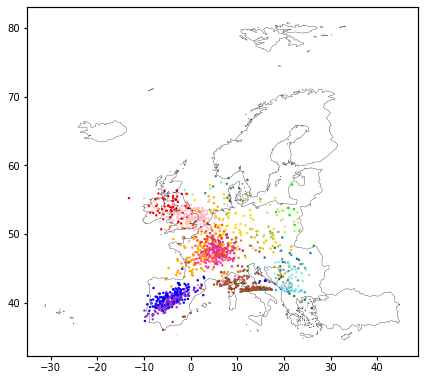

In [568]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set_aspect('equal')
#ax.legend(novcolor.country, novcolor.color)
#fig.set_dpi(200)
euro.boundary.plot(ax=ax, edgecolor="black", linewidth=0.3);
predict.plot(ax=ax, color=predict.color, markersize=2);
#true.plot(ax=ax, color=predict.color, markersize=6);
plt.show();

In [569]:
euro_union = cascaded_union(euro.convex_hull.geometry)
predict_nparray = points_to_coords(predict.geometry)

AttributeError: 'int' object has no attribute 'coords'

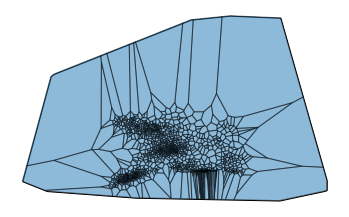

In [570]:
# Calculate Voronoi Regions
poly_shapes, pts = voronoi_regions_from_coords(predict_nparray, euro_union)
#poly_shapes, pts, poly_to_pt_assignments 

fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, euro_union, poly_shapes, pts)
#ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments
#ax.set_title('Voronoi regions of Schools in Uppsala')
#plt.tight_layout()
plt.show()

In [572]:
vor = gpd.GeoDataFrame()
for shape in poly_shapes:
    new = gpd.GeoDataFrame(crs='EPSG:4326', geometry=[poly_shapes[shape]])
    vor = vor.append(new)
    
vor = gpd.GeoDataFrame(vor, crs='EPSG:4326')
vor_predict = gpd.sjoin(vor, predict)
vor_eigs = pd.merge(vor_predict, eigs, on='ID', how='left')
vor_eigs.rename(columns={'index_right':'vor_index'}, inplace=True)

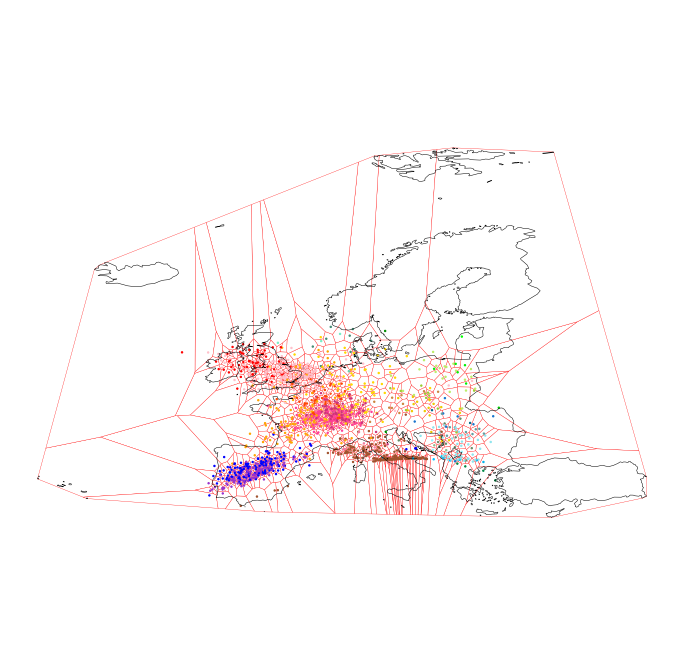

In [582]:
#Check it looks right
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal')
#euro.plot(ax=ax, )
euro.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5);
vor_eigs.plot(ax=ax, color = "white", edgecolor="red", linewidth=0.3);
predict.plot(ax=ax, color=predict.color, markersize=2);
#gdf_nodes.plot(ax=ax, color = 'orange') #london
ax.axis('off')
plt.axis('equal')
plt.show()

## Cosign Similarity

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
#euro.plot(ax=ax, )
vor_eigs.plot(ax=ax)
gdf_nodes.plot(ax=ax, color = 'orange') #london
ax.axis('off')
plt.axis('equal')
plt.show()

In [ ]:
DNAnodes = gpd.sjoin(gdf_nodes, vor_eigs, how='left')
DNAnodes = DNAnodes.loc[:, '1.537':'1.325']
#novcolor
# loop cosign
# ask laos for data
#DNAnodes.columns

In [ ]:
jumps = [25, 26, 32, 33]

for j in jumps:
    level = jumps.index(j)
    # retrieve the nodes in this jump
    jump = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership_p"+str(j)+'.txt')) 
    jump['level'] = level
    jump = jump[['level', 'node_id', 'cluster_id']]
    
    # subset clusters of a minimum size
    sizes = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(j)+'.txt'))
    clusters = sizes[sizes.cluster_size > 2] 
    nodes = pd.merge(jump, clusters, on='cluster_id') #.add_suffix(level) 

    # add the DNA PC components to the nodes in this jump
    DNAjumpnodes = pd.merge(DNAnodes, nodes, how = 'right', left_index = True, right_on = 'node_id')
    
    # find the weighted average PC values for each cluster in this jump
    DNAjumpclusters = DNAjumpnodes.groupby('cluster_id').mean().sort_values('cluster_size', ascending = False)
    
    # cosign similarity between two largest clusters
    largest = DNAjumpclusters.iloc[[0]].loc[:,'1.387':'1.317']
    larger = DNAjumpclusters.iloc[[1]].loc[:,'1.387':'1.317']
    print(sk.pairwise.cosine_similarity(largest, larger))

## TOC:
* [Percolation](#Percolation)
* [Tree](#Tree)
* [Twitter](#Twitter)
* [ESS-NUTS](#ESS)
* [DNA](#DNA)
* [Imagery](#Imagery)
* [Bokeh](#Bokeh)

## Imagery

# Bokeh

In [ ]:
from bokeh.io import output_notebook, show, output_file, show, output_notebook, push_notebook, export_png
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4, brewer
from bokeh.models import CustomJS, Dropdown, ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool


from bokeh.tile_providers import CARTODBPOSITRON, get_provider

from bokeh.io import output_file, show, output_notebook, push_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool



output_notebook()

In [ ]:
import bokeh

In [ ]:
from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="", toolbar_location=None)

graph = from_networkx(G, nx.spring_layout, scale=2, center=(0,0))
plot.renderers.append(graph)

output_file("networkx_graph.html")
show(plot)

### Network

In [ ]:
G = nx.from_pandas_edgelist(edgelist, 'Child.', 'Parent.')

In [ ]:
pip install pydot

In [ ]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from networkx import pygraphviz_layout

In [ ]:
#pos = graphviz_layout(G, prog="dot")

nx.draw(G,
        pos = pygraphviz_layout(G),
        #with_labels = True,
        node_color='blue',
        font_color="white",
        font_weight='bold')
#plt.savefig('hierarchy.png')

In [ ]:
#https://networkx.org/documentation/stable/reference/algorithms/tree.html
print(
    nx.is_tree(G),
    nx.is_forest(G),
    #nx.is_arborescence(G),
    #nx.is_branching(G)
)
